### **Capstone Project: Food Vision**

**SETTING UP NOTEBOOK**

In [5]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**select working directory/folder**

In [6]:
%cd drive/MyDrive/food_vision_capstone_project/

/content/drive/MyDrive/food_vision_capstone_project


In [ ]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

# operating system handling
import os

# extra functionalities
import important_functionalities as impf

**1. Using Tensorflow datasets to download and explore data**
* Data is already loaded in tensor format
* These datasets are static and don't change like real world datasets

In [ ]:
# use tensorflow datasets
import tensorflow_datasets as tfds

# listing all available datasets:
datasets_list=tfds.list_builders()
'food101' in datasets_list # Is our target dataset in list of tfds datasets

True

**To avoid data loss, and re-download frequently we copy it to drive and re-copy instead of re-downloading**

**Note:** This is the most important step, because whenever the runtime resets entire data was lost multiple times, now we can just copy it back to that location with every runtime reset, instead of downloading it multiple times

In [ ]:
# !sudo cp -r /root/tensorflow_datasets/food101/ .

In [ ]:
ls /root/tensorflow_datasets/

downloads/  food101/


In [ ]:
!sudo cp -r food101/ /root/tensorflow_datasets/

In [ ]:
# loading food101:
(train_data,test_data),ds_info = tfds.load(name='food101',
                                           split=['train','validation'],
                                           shuffle_files=True,
                                           as_supervised=True, # we want labels in data (tuple format)
                                           with_info=True # we need info of dataset
                                           )


**1.1. Becoming one with data**
* check features using `ds_info`
* get class_names
* get the shape of our input data (image - tensors)
* get the datatype of our input data
* what the labels look like? (one-hot-encoded or numeric integer/label-encoded)
* do labels match up with class_names?



In [ ]:
# features of Food101 from TDFS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# getting class names
class_names=ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# take one sample of train data
train_one_sample=train_data.take(1)
train_one_sample


<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# output info about our one training sample
for image,label in train_one_sample:
  print(f'image shape: {image.shape}')
  print(f'image datatype: {image.dtype}')
  print(f'target class from Food101 dataset: {label}')
  print(f'Class name (str form):{class_names[label]}')
  print(image)

# observation: labels are not one-hot-encoded
#              images are in 'uint8', needs normalization

image shape: (512, 512, 3)
image datatype: <dtype: 'uint8'>
target class from Food101 dataset: 31
Class name (str form):donuts
tf.Tensor(
[[[131  86  55]
  [134  89  58]
  [137  92  61]
  ...
  [131  44   0]
  [135  49   2]
  [138  52   5]]

 [[134  89  58]
  [135  90  59]
  [135  90  59]
  ...
  [133  46   1]
  [134  48   1]
  [134  48   1]]

 [[136  91  60]
  [137  92  61]
  [139  94  63]
  ...
  [137  53   7]
  [135  51   5]
  [131  47   1]]

 ...

 [[130  23   3]
  [134  31  14]
  [132  36  24]
  ...
  [243 248 242]
  [243 248 242]
  [243 248 242]]

 [[128  22   0]
  [129  26   7]
  [124  28  14]
  ...
  [243 248 241]
  [242 247 240]
  [242 247 240]]

 [[132  26   2]
  [133  31   9]
  [126  29  13]
  ...
  [242 247 240]
  [242 247 240]
  [242 247 240]]], shape=(512, 512, 3), dtype=uint8)


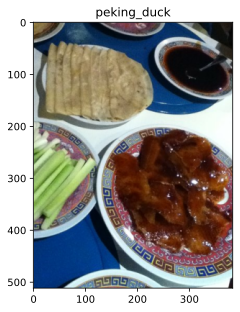

In [ ]:
# plot an image-tensor
plt.imshow(image)
plt.title(class_names[label])
plt.show()

**2. Creating a pre-processing function for our data**
* image in `uint8` dtype
* size of images are not uniform through out
* images are not scaled/normalized
* labels in encoded `int64` dtype

**models needs**
* data type: `float32` or (`float32` or `float16`) for mixed_precision
* images should be in same size
* normalize tensors (not neeeded, as we are using efficientnet, which has layers to rescale)
* labels need not be one-hot-encoded, we can use `SparseCategoricalCrossentropy` loss

In [ ]:
def preprocess_img(image,label,img_shape=(224,224),scale=False):
  img=tf.image.resize(image,size=img_shape)
  if scale:
    img=img/255.0
  label=tf.one_hot(label,depth=len(class_names))
  return tf.cast(img,dtype=tf.float32),label

In [ ]:
print(f"size before pre-processing: {image.shape}")
pre_processed_img=preprocess_img(image,label)[0]
print(f"size after pre-processing: {pre_processed_img.shape}")
print(pre_processed_img)

size before pre-processing: (512, 512, 3)
size after pre-processing: (224, 224, 3)
tf.Tensor(
[[[1.34030609e+02 8.90306168e+01 5.80306129e+01]
  [1.36045914e+02 9.10459213e+01 6.00459175e+01]
  [1.37846939e+02 9.28469391e+01 6.38469391e+01]
  ...
  [1.30265366e+02 4.79183846e+01 1.62753057e+00]
  [1.30760223e+02 4.37602272e+01 4.59267795e-02]
  [1.34739838e+02 4.87398338e+01 1.73983324e+00]]

 [[1.41551025e+02 9.65510254e+01 6.55510254e+01]
  [1.49081650e+02 1.04081635e+02 7.30816345e+01]
  [1.51632660e+02 1.06632652e+02 7.56326523e+01]
  ...
  [1.30357101e+02 4.85713654e+01 1.99989128e+00]
  [1.34147995e+02 5.01479988e+01 4.14799976e+00]
  [1.33571289e+02 4.95712891e+01 3.57128906e+00]]

 [[1.44571426e+02 9.79285660e+01 6.49285660e+01]
  [1.36540817e+02 8.98979568e+01 5.68979568e+01]
  [1.35780624e+02 8.93520432e+01 5.49234695e+01]
  ...
  [1.31403122e+02 4.91683922e+01 4.87758541e+00]
  [1.29285721e+02 4.75000153e+01 9.28585052e-01]
  [1.30857101e+02 4.90713959e+01 2.49996567e+00]]



**3. Batching and preparing datasets for modelling**

In [ ]:
# batching and preparing datasets

### map pre-processing function to training data and also parallelize it
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
### shuffle train_data and turn it into batches and prefetch it (load it faster)

# # # shuffle(buffer_size): number of samples to shuffle at a time (ideally len(train_data), to reduce compute, set to low value)
# # # prefetch(buffer_size):
BATCH_SIZE = 32
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

### map pre-processing function to testing data and also parallelize it
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)

### Turn it into batches and prefetch it (load it faster)
# # # cache() only works if dataset can fit into RAM
# test_data=test_data.batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
test_data=test_data.batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

**Note:** The above code, tells tensorflow to map our preprocessing function `preprocess_img()` across our training dataset, shuffle a number of elements, and batch them together.
Make sure you prepare new batches (prefetch) whilst the model trains the current batch.

**4. Setting up callbacks and mixed-precision training (faster model training)**
* Among NVIDIA GPUs, those with compute capability 7.0 or higher will see the greatest performance benefit from mixed precision because they have special hardware units, called Tensor Cores, to accelerate float16 matrix multiplications and convolutions.
* We are using NVIDIA T4	(compute capability: 7.5) in Google colab
* Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance
* Calculations are done in float16, while storage is done in float32.
* The output prediction/softmax won't be numerically stable with float16, hence needs dtype: float32

**callbacks:**
* Tensorboard
* ModelCheckpoint

In [ ]:
# create modelling callbacks
### modelcheckpoint callback
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    save_best_only=True,
                                                    monitor='val_accuracy',
                                                    verbose=1)

In [ ]:
!nvidia-smi

Sun Mar 16 06:01:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# turn on mixed-precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # data type policy

**5. Building the feature extraction model**
* for this experiment/project we haven't done data augmentation

In [ ]:
# Build a headless (no top layers) Functional EfficientNetB0 model
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)

base_model.trainable=False

# Setup model architecture with trainable top
inputs=tf.keras.layers.Input(shape=input_shape, name='input_layer')
x=base_model(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x=tf.keras.layers.Dense(len(class_names),name='dense_output_layer')(x)
### mixed precision requires output layer (softmax) to have dtype=tf.float32 --> compulsory
output=tf.keras.layers.Activation('softmax',dtype=tf.float32,name='softmax_float32')(x)

model=tf.keras.Model(inputs,output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_output_layer (Dense)           │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# training the feature extraction model

# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[impf.create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])


Saving TensorBoard log files to : training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250319-052321
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4590 - loss: 2.3604
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 227s 81ms/step - accuracy: 0.4591 - loss: 2.3601 - val_accuracy: 0.6875 - val_loss: 1.1806
Epoch 2/3
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6542 - loss: 1.3427
Epoch 2: val_accuracy improved from 0.68750 to 0.72087, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 174s 72ms/step - accuracy: 0.6542 - loss: 1.3427 - val_accuracy: 0.7209 - val_loss: 1.0588
Epoch 3/3
2366/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6891 - loss: 1.1859
Epoch 3: val_accuracy improved from 0.72087 to 0.72617, saving model to model_checkpoints/cp.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 72ms/step - accuracy: 0.6891 - 

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.7270 - loss: 1.0113


[1.0079476833343506, 0.7268911004066467]

**6. loading and evaluating model using checkpoint weights**

1. Recreating a new instance of our model called `created_model` by turning our original model creation code into a function called `create_model()`.
2. Compiling our `created_model` with the same loss, optimizer and metrics as the original model (every time you create a new model, you must compile it).
3. Calling the `load_weights()` method on our `created_model` and passing it the path to where our checkpointed weights are stored.
4. Calling `evaluate()` on `created_model` with loaded weights and saving the results.
5. Comparing the `created_model` results to our previous `model` results (these should be the exact same, if not very close).


In [ ]:
def create_model():
  input_shape=(224,224,3)
  base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
      include_top=False,
      weights='imagenet',
      input_shape=input_shape,
  )

  base_model.trainable=False

  # Setup model architecture with trainable top
  inputs=tf.keras.layers.Input(shape=input_shape, name='input_layer')
  x=base_model(inputs,training=False)
  x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
  x=tf.keras.layers.Dense(len(class_names),name='dense_output_layer')(x)
  ### mixed precision requires output layer (softmax) to have dtype=tf.float32 --> compulsory
  output=tf.keras.layers.Activation('softmax',dtype=tf.float32,name='softmax_float32')(x)

  model=tf.keras.Model(inputs,output)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.7276 - loss: 1.0100


In [ ]:
results_created_model_with_loaded_weights

[1.007867693901062, 0.7268514633178711]

**7. Creating function to get top-k accuracy using test dataset**

In [ ]:
# Function to compute top-k accuracy
def compute_top_k_accuracy(model, dataset, k=1):
    correct_count = 0
    total_count = 0

    for images, labels in dataset:
        # Get predictions (logits)
        logits = model.predict(images, verbose=0)

        # Get top-k class indices using tf.math.top_k
        top_k_preds = tf.math.top_k(logits, k=k).indices.numpy()  # Shape: (batch_size, k)

        # Convert labels tensor to numpy and extract class indices if needed
        labels = labels.numpy()  # Check if labels are one-hot encoded
        if labels.ndim > 1 and labels.shape[1] > 1:  # If one-hot encoded
            labels = np.argmax(labels, axis=1)  # Convert to class indices

        # Use vectorized operation to check if true labels are in top-k predictions
        correct_count += np.sum(np.any(top_k_preds == labels[:, None], axis=1))
        total_count += len(labels)

    return correct_count / total_count

compute_top_k_accuracy(created_model,test_data,k=5)

np.float64(0.9198415841584159)

In [ ]:
results_created_model_with_loaded_weights

[1.0078669786453247, 0.7268514633178711]

In [ ]:
# saving the feature extraction model
created_model.save('models/feature_extraction_model.keras')

In [ ]:
# loading saved model
loaded_saved_model = tf.keras.models.load_model('models/feature_extraction_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# evaluate on loaded model
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.7272 - loss: 1.0117


[1.0078673362731934, 0.7268514633178711]

**8. Preparing model layers for fine-tuning**

In [ ]:
# setting all layers trainable
for layer in loaded_saved_model.layers:
    layer.trainable = True # set all layers to trainable

for layer in loaded_saved_model.layers[1].layers:
    print(layer.name,layer.trainable,layer.dtype_policy)

input_layer_2 True <DTypePolicy "float32">
rescaling_2 True <DTypePolicy "float32">
normalization_2 True <DTypePolicy "float32">
stem_conv True <DTypePolicy "float32">
stem_bn True <DTypePolicy "float32">
stem_activation True <DTypePolicy "float32">
block1a_project_conv True <DTypePolicy "float32">
block1a_project_bn True <DTypePolicy "float32">
block1a_project_activation True <DTypePolicy "float32">
block2a_expand_conv True <DTypePolicy "float32">
block2a_expand_bn True <DTypePolicy "float32">
block2a_expand_activation True <DTypePolicy "float32">
block2a_project_conv True <DTypePolicy "float32">
block2a_project_bn True <DTypePolicy "float32">
block2b_expand_conv True <DTypePolicy "float32">
block2b_expand_bn True <DTypePolicy "float32">
block2b_expand_activation True <DTypePolicy "float32">
block2b_project_conv True <DTypePolicy "float32">
block2b_project_bn True <DTypePolicy "float32">
block2b_drop True <DTypePolicy "float32">
block2b_add True <DTypePolicy "float32">
block3a_expand_

**9. `EarlyStopping` callback and `ReduceLRonPlateau()` callback setup**

* The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

* Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

* The `ReduceLROnPlateau` callback helps to tune the learning rate for you. Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).
* We need to ensure that learning rate doesn't go too low (model stops learning), hence we set a minimum learning rate

In [ ]:
# early stopping
early_stopping=tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                patience = 3 # stop training if model's val_loss doesn't improve for 3 epochs
                                                )
# model checkpoint
checkpoint_path = "model_checkpoints/cp_finetuning.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      monitor="val_loss")

# reduce learning rate on plateau
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                               factor=0.2, # lr=0.2*lr
                                               patience=2,
                                               verbose=1, # print when lr goes down
                                               min_lr=1e-7
                                               )

**10. Fine-tuning feature extraction model to beat Deep Food paper**
* https://arxiv.org/pdf/1606.05675

In [ ]:
loaded_saved_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(0.0001), # reduce lr for fine-tuning
                           metrics=['accuracy'])

In [ ]:
# fitting the model:
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                                      epochs=100, # fine-tune for a maximum of 100 epochs
                                                                      steps_per_epoch=len(train_data),
                                                                      validation_data=test_data,
                                                                      validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                                      callbacks=[impf.create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_fine_tuning"),
                                                                                 model_checkpoint, # save only the best model during training
                                                                                 early_stopping, # stop model after X epochs of no improvements
                                                                                 reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to : training_logs/efficientnetb0_101_classes_all_data_fine_tuning/20250319-072237
Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 447s 150ms/step - accuracy: 0.6432 - loss: 1.4052 - val_accuracy: 0.8136 - val_loss: 0.6775 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 326s 136ms/step - accuracy: 0.8057 - loss: 0.7307 - val_accuracy: 0.8236 - val_loss: 0.6298 - learning_rate: 1.0000e-04
Epoch 3/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 377s 134ms/step - accuracy: 0.8615 - loss: 0.5150 - val_accuracy: 0.8316 - val_loss: 0.6086 - learning_rate: 1.0000e-04
Epoch 4/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 325s 135ms/step - accuracy: 0.9081 - loss: 0.3511 - val_accuracy: 0.8411 - val_loss: 0.5850 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 378s 134ms/step - accuracy: 0.9344 - loss: 0.2495 - val_accuracy: 0.8387 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 6/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.95

In [ ]:
# saving fine-tuned model
loaded_saved_model.save('models/fine_tuned_model.keras')

**11. Evaluating model and comparing with DeepFood**

DeepFood: Deep Learning-based Food Image
Recognition for Computer-aided Dietary Assessment
https://arxiv.org/pdf/1606.05675

**Results:**

| No of Iterations | Top-1 Accuracy | Top-5 Accuracy |
|----------------|---------------|---------------|
| 10,000        | 70.2%         | 91.0%         |
| 30,000        | 74.7%         | 93.0%         |
| 50,000        | 75.1%         | 93.0%         |
| 70,000        | 74.0%         | 92.1%         |
| 90,000        | 76.3%         | 93.4%         |
| 160,000       | 76.6%         | 93.4%         |
| 180,000       | 77.2%         | 93.3%         |
| 200,000       | 76.9%         | 93.4%         |
| 250,000       | **77.4%**     | **93.7%**     |
| 300,000       | 76.4%         | 93.0%         |


<Figure size 640x480 with 0 Axes>

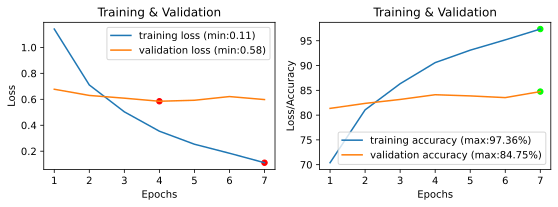

In [ ]:
impf.plot_loss_curves(history_101_food_classes_all_data_fine_tune)

In [ ]:
loaded_saved_model=tf.keras.models.load_model('models/fine_tuned_model.keras')

In [ ]:
# Compute Top-1 and Top-5 Accuracy
_, top_1_acc = loaded_saved_model.evaluate(test_data)  # Get accuracy from model's built-in evaluate()

print(f"Top-1 Accuracy: {top_1_acc:.4%}")

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 65ms/step - accuracy: 0.8434 - loss: 0.6006
Top-1 Accuracy: 84.3485%


In [ ]:
# Compute Top-5 Accuracy
top_5_acc = compute_top_k_accuracy(loaded_saved_model, test_data, k=5)
print(f"Top-5 Accuracy: {top_5_acc:.4%}")


Top-5 Accuracy: 96.4990%


|Model| No of epochs | Top-1 Accuracy | Top-5 Accuracy |
|---|----------------|---------------|---------------|
|DeepFood|2,50,000|77.4%|93.7%|
|Feature Extraction Efficient Net B0|3|72.6851%|91.9841%|
|Fine tuned Efficient Net B0 |7|84.3485%|96.4990% |
